In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.circuit.library import QFT, CPhaseGate

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

def convert(bin: str):                  #konvertiert den bitstring in deciaml, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n


def QPE(angle: float, precision: int) -> QuantumCircuit:
    qr = QuantumRegister(precision+1,"q")
    cbit = ClassicalRegister(precision,"c")
    qc = QuantumCircuit(qr,cbit)
    
    qc.x(precision)

    for i in range(precision):
        qc.h(i)
        for j in range(2**(i)):
            qc.cp(theta=2*np.pi*angle, control_qubit=i, target_qubit=precision)

    qft = QFT(num_qubits=precision, inverse=True).to_gate()
    hmm = [i for i in range(precision)]         #Liste der Qubits auf denen iQFT andgewendet wird
    qc.append(qft,qargs=hmm)
    return qc

def gen_data(name, angle: float, shots: int, n: int, steps:int):
    soweit = 0.4
    error = np.linspace(0,soweit,steps)
    x = np.linspace(0,soweit,steps)
    y = np.zeros(steps)
    for j in range(len(error)):

        p = error[j]
        p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
        p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(p_error, ['x',"z",'h',"s","t","tdg","sdg"])  # Apply to single-qubit gates
        noise_model.add_all_qubit_quantum_error(p_error_2, ["cx"])  # Apply to 2-qubit gates

        qc = QPE(angle=angle, precision=n)

        for i in range(n):
            qc.measure(i,i)

        sim = AerSimulator()
        job = sim.run(qc.decompose(reps=n), noise_model=noise_model, shots=shots)
        result = job.result()
        counts = result.get_counts() 

        most = convert(max(counts, key=counts.get))
        y[j] += np.abs(most-angle)

    data = np.array((x,y))
    fig, ax = plt.subplots(figsize=(13,7))
    ax = plt.plot(x,y, "x", label="Precision", linestyle = "dotted")

    plt.title("iQPE: Dependence of Precision on the depolarizing errror with "+r"$\Theta$"+" = {}, {} iterations and {} shots".format(angle, n, int(shots)))
    plt.yscale("log")
    plt.ylabel(r"$\vert \text{max}(\varphi) - \Theta \vert$")
    plt.xlabel("Pauli error")
    plt.legend()    

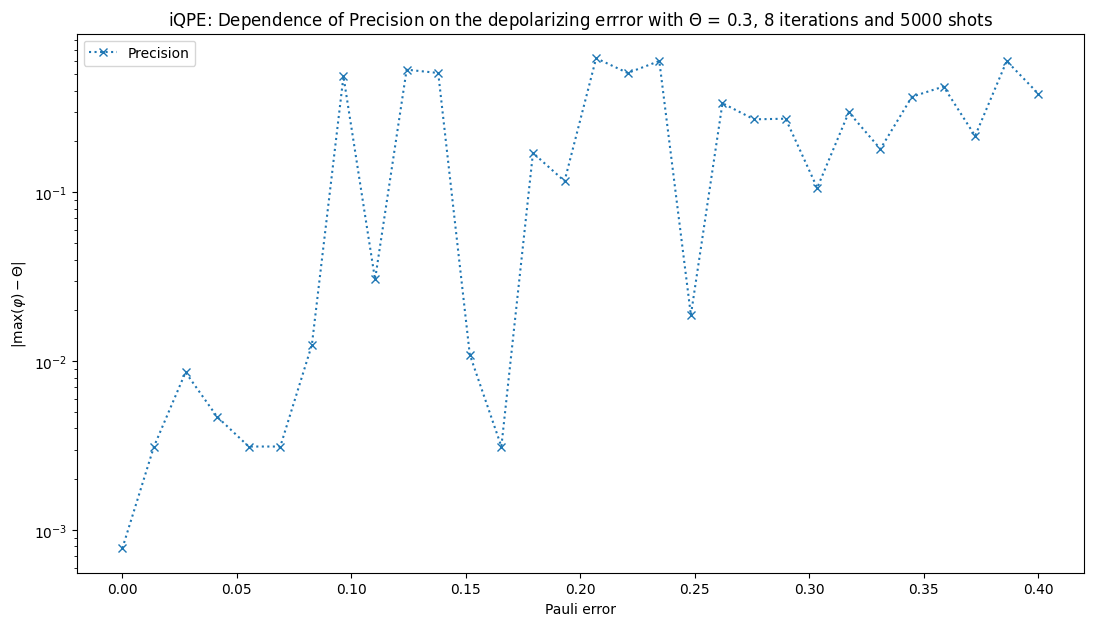

In [4]:
gen_data(5, 0.3, 5000, 8, 30)